# Michelin NLP Capstone Project 
### Presented by: Yuvia Cardenas, Justin Evans, Cristina Lucin, and Woody Sims

## Project Overview

This project focuses on building a prediction model for accurately predicting the coding language of a project using examination of GitHub repo Readme files. Our goal is to develop a predictive model utilizing Python and Python libraries and select the most effective model for production. Initially, we are utilizing BeautifulSoup to acquire our data, selecting 1000 repositories tagged with 'Minecraft' from GitHub, taking in all Readme text and repo language information from each repo. After gathering the data, we explore the data through questions and visualizations before developing a model that can tell us: "What language is this repository most likely to be written in?"

## Goals

### Create deliverables:
- READ ME
- Final Report (Jupyter Notebook)
- Functional acquire.py, explore.py, and model.py files
- Acquire data from Michelin Website utilizing Beautiful Soup to scrape restaurant review text
- Prepare and split the data
- Explore the data and produce visualizations encapsulating exploration
- Establish and document baseline
- Fit and train a classification model to predict the programming language of the Repo
- Evaluate the model by comparing its performance on train utilizing accuracy as a measure
- Evaluate the selected model on test data
- Develop and document findings, takeaways, recommendations, and next steps

In [56]:
# Imports

import pandas as pd
import numpy as np
import re
import os

# Webscraping/NLP
import requests
from requests import get
from bs4 import BeautifulSoup
import time
import nltk
import requests
import unicodedata
from nltk.corpus import stopwords

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

## setting basic style parameters for matplotlib
plt.rc('figure', figsize=(20, 10))
plt.style.use('seaborn-darkgrid')


# Stats
import scipy.stats as stats
from scipy.stats import ttest_ind, levene, f_oneway

# Team Imports

import prepare as p
import acquire as a
import explore as e
import model as m
from importlib import reload
import warnings
warnings.simplefilter("ignore")


# Acquire
- 6,780 Michelin website page URLs were acquired from a Michelin Kaggle Dataset of the current, quarterly Michelin Restaurants in the world (Kaggle Data Acquired 1/18/2023)
- These website pages were scraped utilizing BeautifulSoup utilizing a function called "get_michelin_pages"
- The text from the restaurant review was appended to the original Michelin Dataframe as a column titled "data"
- This dataframe included 6,780 rows before cleaning
- Each row represents a unique restaurant awarded and currently possessing a Michelin guide award designation
- Each column represents a feature of the restaurant, such as name, location, cuisine type, and price level

# Prepare
### Prepare Actions:
- Removed columns not necessary for project goals
- Dropped rows "restaurants" who no longer appear on the Michelin Guide Website (No longer a current Michelin Awardee)
- Recasted columns into different data types as appropriate
- Checked for null values in the data, imputed null values where applicable
- Utilized Regex and string methods and functions to clean restaurant review text
- Renamed columns and applied lowercase text to columns and data to improve readability/usability
- Tokenized review text, removed stopwords, and lemmatized text for exploration and modeling

In [57]:
# Get the data, take a peek
df = a.get_michelin_pages()
df.head()

,name,address,location,price,cuisine,longitude,latitude,phone_number,url,website_url,award,facilities_and_services,data
0,King's Joy,"2 Wudaoying Hutong, Beijing, China Mainland","Beijing, China Mainland",¥¥¥,Vegetarian,116.410004,39.946681,8.610840e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","Just a stone’s throw from Yonghe Temple, this ..."
1,Xin Rong Ji (Xinyuan South Road),"1F, East Tower, Genesis Beijing, 8 Xinyuan Sou...","Beijing, China Mainland",¥¥¥¥,Taizhou,116.450148,39.946380,8.610650e+11,https://guide.michelin.com/en/beijing-municipa...,NaN,3 MICHELIN Stars,"Air conditioning,Car park,China UnionPay,Count...",This branch of the chain restaurant opened in ...
2,Taian Table,"101-102, Building No. 1, Garden Office, No.161...","Shanghai, China Mainland",¥¥¥¥,Innovative,121.474049,31.221807,8.617302e+12,https://guide.michelin.com/en/shanghai-municip...,https://taian-table.cn/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",A fixture on the city’s dining scene since 201...
3,Ultraviolet by Paul Pairet,'somewhere in Shanghai' - meet at Mr & Mrs Bun...,"Shanghai, China Mainland",¥¥¥¥,Innovative,121.485090,31.240358,NaN,https://guide.michelin.com/en/shanghai-municip...,https://uvbypp.cc/,3 MICHELIN Stars,"Air conditioning,American Express credit card,...",This multi-sensory experience at a secret loca...
4,Quince,"470 Pacific Ave., San Francisco, 94133, USA","San Francisco, USA",$$$$,"Contemporary, Californian",-122.403261,37.797505,1.415776e+10,https://guide.michelin.com/en/california/san-f...,http://www.quincerestaurant.com,3 MICHELIN Stars,"Air conditioning,American Express credit card,...","An air of refinement infuses this dining room,..."


In [58]:
# Take a look at some restaurant reviews from our dataframe:
print(f'Kings Joy (Beijing, China) review text: {df.data[0]}')

Kings Joy (Beijing, China) review text: Just a stone’s throw from Yonghe Temple, this serene restaurant is remodelled from a courtyard house and features a glass-roofed dining room. The chef honed his skills at his grandparents’ restaurant of the same name. Only set menus are available; try the classic menu to sample their specialities all at once. Regulars may opt for the solar-term menu that changes every 15 days. Live harp performance befits the restaurant’s classy elegance.


In [59]:
# Take a look at some restaurant reviews from our dataframe:
print(f'La Palme dOr (Cannes, France) review text: {df.data[500]}')

La Palme dOr (Cannes, France) review text: Some places you fall in love with at first sight and La Palme d'Or is one of them. In the fabulous Art Deco setting of the Hotel Martinez, diners look down on the famous promenade of La Croisette and the Bay of Cannes, while savouring the luxury and refinement so beautifully brought together here. Of course, all this would be worth nothing without high-calibre cuisine. No worries on that score: chef Christian Sinicropi, a local man, has matters entirely in hand. At each stage of the "Mouvements" set menu, he homes in on one ingredient, supporting it with elements from its own ecosystem. The result is coherent and sophisticated, right down to the remarkably precise desserts by Julien Ochando. Definitely worthy of a Golden Palm award.


_________________________________

# Exploration

In [60]:
# Splitting our data (56% Train, 24% Validate, 20% Test)
train, validate, test = p.prepare_michelin(df)
train.head(2)

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9648,36
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9618,32


## Question 1: What is the distribution of our target variable (award type)?

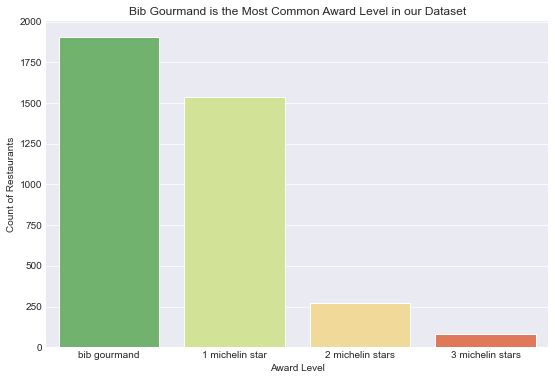

In [61]:
# Generate visuazliation of distribution of target variable
e.get_award_freq(train)

In [62]:
# Establishing Baseline for modeling, with the Mode being 'bib gourmand'
len(train[train.award == 'bib gourmand']) / len(train.award)

0.5030319008700237

## Question 2: What Countries have the most Michelin Restaurants?

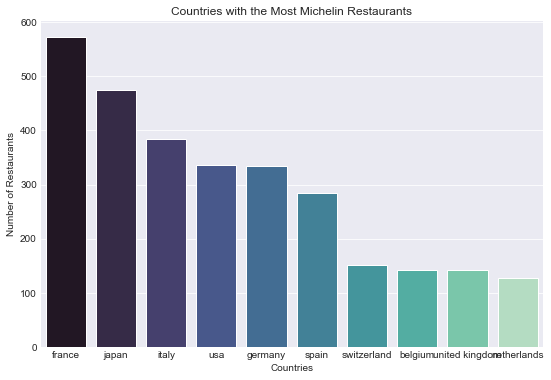

In [63]:
# Generate visualizaion of count of Michelin awardees by country
e.top_10_country_viz(train)

## Question 3: What is the average wordcount of restaurant reviews, by award type?

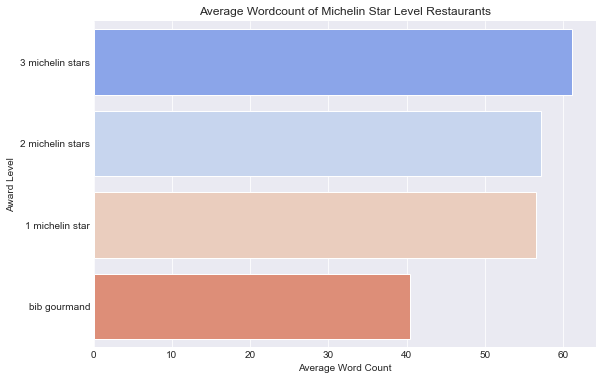

In [64]:
# Generate Visualization of average wordcount by Michelin award category
e.get_wordcount_bar(train)

### We conducted an ANOVA (Analysis of Variance) test to determine if there is a significant difference in review wordcount:

In [65]:
# Generate visualization of wordcount by award category
e.get_anova_wordcount(train)

We reject the null hypothesis. There is sufficient
evidence to conclude that the word count is significantly
different between award categories.
Test Statistic: 303.0297031546263, P Statistic: 2.484073504071232e-176


## Question 4: Do three star Michelin restaurants have the highest sentiment score?

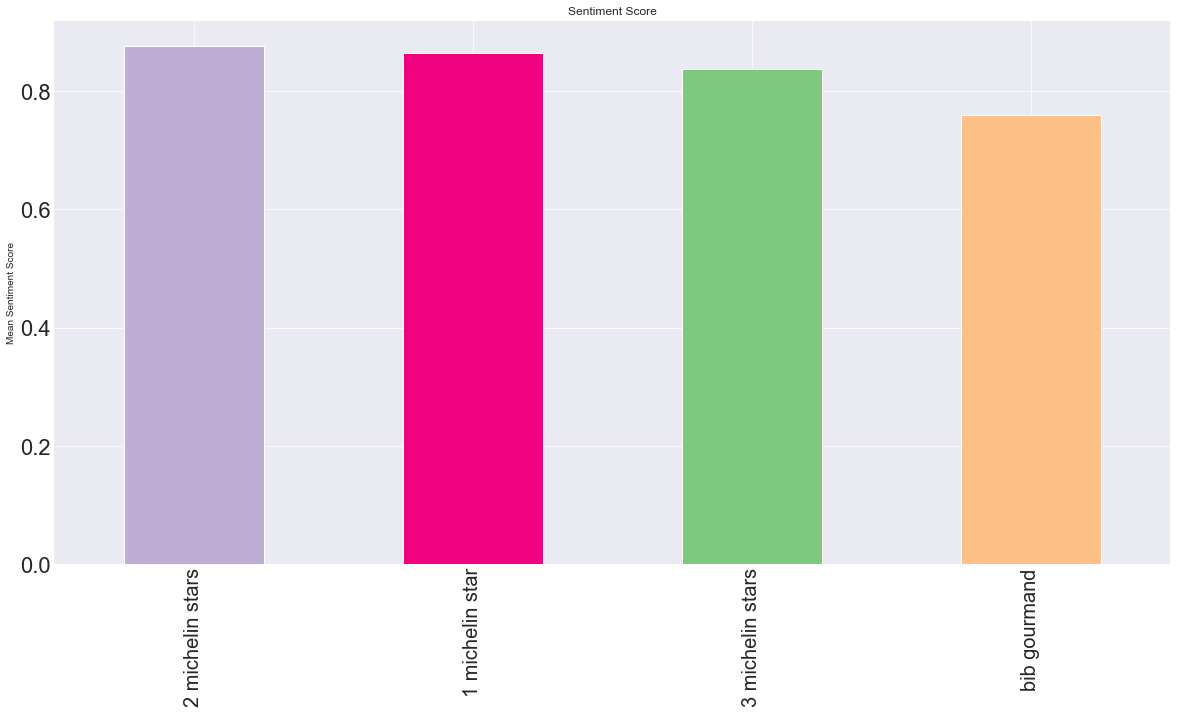

In [67]:
# Generate visualization for sentiment score
e.sentiment_scores_bar(train)

- Sentiment scores for all categories are generally favorable
- Restaurants awarded three (3) Michelin stars had the highest sentiment score

## Question 5: What are the most frequent words used in Michelin Restaurant reviews?

In [68]:
# Custom function to create facilities DataFrame
from typing import List, Union, Tuple

def prepare_facilities(df: pd.DataFrame,
                     split: bool = True) -> Union[pd.DataFrame,
                                                  Tuple[pd.DataFrame,
                                                        pd.DataFrame,
                                                        pd.DataFrame]]:
    '''
    Prepares Michelin DataFrame
    ## Parameters
    df: `DataFrame` with Michelin data
    split: Boolean for whether or not to split the data, default True
    ## Returns
    either a DataFrame or a tuple of the Train, Validate, and Test
    `DataFrame`
    '''
    df = p.create_features(df)
    df = p.change_dtype_str(df)
    df = pd.concat([df, p.process_nl(df.facilities_and_services)], axis=1)
    if split:
        return p.tvt_split(df, stratify='award')
    return df

In [69]:
# Run Facilities split
f_train, f_validate, f_test = prepare_facilities(df)

In [70]:
# create word_count for facilities
f_train['word_count'] = f_train.lemmatized.str.split().apply(len)

In [71]:
###################################
##### CREATE review variables #####
###################################

# Assign all, 1_star, 2_star, 3_star and bib_gourmand reviews by passing the function with a join
all_reviews = (' '.join(train['lemmatized']))
one_star_reviews = (' '.join(train[train.award == '1 michelin star']['lemmatized']))
two_star_reviews = (' '.join(train[train.award == '2 michelin stars']['lemmatized']))
three_star_reviews = (' '.join(train[train.award == '3 michelin stars']['lemmatized']))
bib_gourmand_reviews = (' '.join(train[train.award == 'bib gourmand']['lemmatized']))

# Break them all into word lists with split 
all_reviews_words = all_reviews.split()
one_star_reviews_words = one_star_reviews.split()
two_star_reviews_words = two_star_reviews.split()
three_star_reviews_words = three_star_reviews.split()
bib_gourmand_reviews_words = bib_gourmand_reviews.split()

# Assign word counts to Frequency Variables
freq_one_star_reviews = pd.Series(one_star_reviews_words).value_counts()
freq_two_star_reviews = pd.Series(two_star_reviews_words).value_counts()
freq_three_star_reviews = pd.Series(three_star_reviews_words).value_counts()
freq_bib_gourmand_reviews = pd.Series(bib_gourmand_reviews_words).value_counts()
freq_all_reviews = pd.Series(all_reviews_words).value_counts()

#######################################
##### CREATE facilities variables #####
#######################################

# Assign all, 1_star, 2_star, 3_star and bib_gourmand lists by passing the clean function with a join
all_facilities = ' '.join(f_train['lemmatized'])
one_star_facilities = ' '.join(f_train[f_train.award == '1 michelin star']['lemmatized'])
two_star_facilities = ' '.join(f_train[f_train.award == '2 michelin stars']['lemmatized'])
three_star_facilities = ' '.join(f_train[f_train.award == '3 michelin stars']['lemmatized'])
bib_gourmand_facilities = ' '.join(f_train[f_train.award == 'bib gourmand']['lemmatized'])

# Break them all into word lists with split 
all_facilities_words = all_facilities.split()
one_star_facilities_words = one_star_facilities.split()
two_star_facilities_words = two_star_facilities.split()
three_star_facilities_words = three_star_facilities.split()
bib_gourmand_facilities_words = bib_gourmand_facilities.split()

# Assign word counts to Frequency Variables
freq_one_star_facilities = pd.Series(one_star_facilities_words).value_counts()
freq_two_star_facilities = pd.Series(two_star_facilities_words).value_counts()
freq_three_star_facilities = pd.Series(three_star_facilities_words).value_counts()
freq_bib_gourmand_facilities = pd.Series(bib_gourmand_facilities_words).value_counts()
freq_all_facilities = pd.Series(all_facilities_words).value_counts()

######################################
##### Create Frequency DataFrame #####
######################################
word_counts = pd.concat([freq_all_facilities,
                         freq_one_star_facilities, 
                         freq_two_star_facilities,
                         freq_three_star_facilities,
                         freq_bib_gourmand_facilities,
                         freq_all_reviews,
                         freq_one_star_reviews,
                         freq_two_star_reviews,
                         freq_three_star_reviews,
                         freq_bib_gourmand_reviews], axis=1
         ).fillna(0).astype(int)

word_counts.columns = ['all_facilities',
                         'one_star_facilities', 
                         'two_star_facilities',
                         'three_star_facilities',
                         'bib_gourmand_facilities',
                         'all_reviews',
                         'one_star_reviews',
                         'two_star_reviews',
                         'three_star_reviews',
                         'bib_gourmand_reviews']

word_counts

,all_facilities,one_star_facilities,two_star_facilities,three_star_facilities,bib_gourmand_facilities,all_reviews,one_star_reviews,two_star_reviews,three_star_reviews,bib_gourmand_reviews
credit,9624,4588,841,259,3936,2,1,0,0,1
card,8754,3872,643,197,4042,5,2,2,0,1
debit,3322,1481,255,78,1508,0,0,0,0,0
air,2579,1144,226,70,1139,33,14,2,1,16
express,2201,1163,229,72,737,27,13,4,3,7
...,...,...,...,...,...,...,...,...,...,...
margon,0,0,0,0,0,1,1,0,0,0
ferrari,0,0,0,0,0,1,1,0,0,0
reliable,0,0,0,0,0,1,1,0,0,0
nijmegen,0,0,0,0,0,1,0,0,0,1


In [72]:
# Most frequent single words
e.get_ngram_frequency(train.lemmatized, n=1).head(5)

modern     831
room       778
kitchen    713
one        662
local      655
dtype: int64

<Figure size 800x400 with 0 Axes>

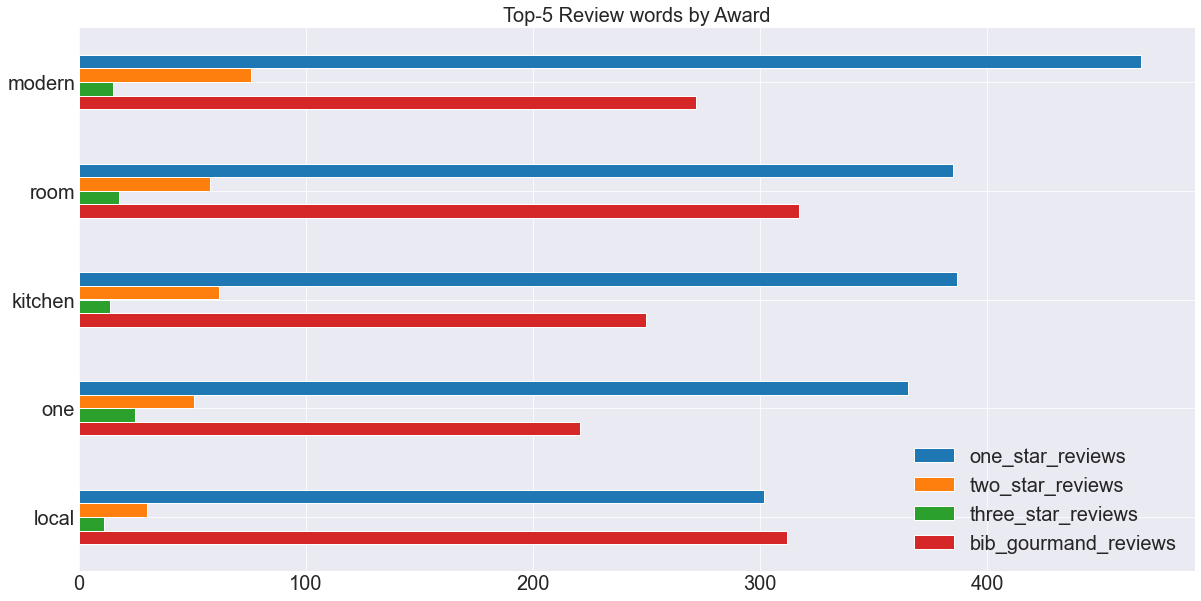

In [77]:
# Plot Top-20 Review Words and compare by Awards
features_list = ['one_star_reviews','two_star_reviews','three_star_reviews','bib_gourmand_reviews']

fontsize = 20
plt.rc('font', size=20)
plt.figure(figsize=(10, 5), dpi=80)

word_counts.sort_values('all_reviews', ascending=False)[features_list].head(5).plot.barh()

plt.gca().invert_yaxis()
plt.title('Top-5 Review words by Award', fontdict={'fontsize': fontsize})

plt.show()

In [78]:
# Most frequent bigrams
e.get_ngram_frequency(train.lemmatized, n=2).head(5)

la carte        213
tasting menu    142
open kitchen    120
set menu        110
foie gras        78
dtype: int64

Text(0.5, 1.0, 'Top-5 Bigrams for All Review words')

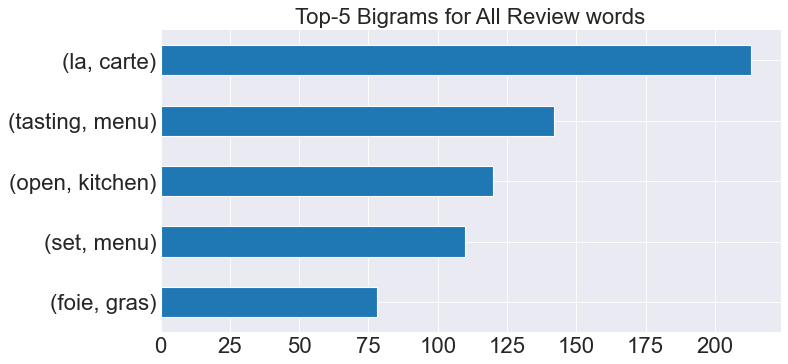

In [79]:
# Display top Bigrams for All Review words

# Set the plot attributes
fontsize = 20
plt.figure(figsize=(10, 5), dpi=80)

# Plot
pd.Series(nltk.bigrams(all_reviews_words)
         ).value_counts().head(5).plot.barh()
plt.gca().invert_yaxis()

plt.title('Top-5 Bigrams for All Review words', fontdict={'fontsize': fontsize})

In [80]:
# Most frequent trigrams
e.get_ngram_frequency(train.lemmatized, n=3).head(5)

two tasting menu         39
take pride place         35
three tasting menu       31
update september 2020    27
last update september    27
dtype: int64

Text(0.5, 1.0, 'Top-5 Trigrams for All Review words')

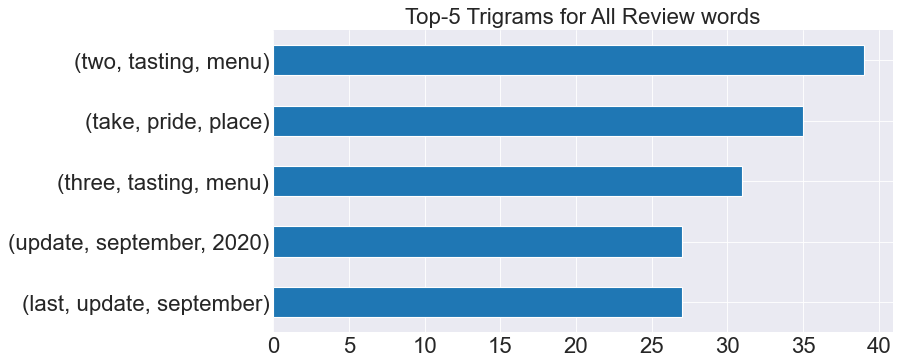

In [81]:
# Display top Trigrams for All Review words

fontsize = 20
plt.figure(figsize=(10, 5), dpi=80)

pd.Series(nltk.ngrams(all_reviews_words, 3)
         ).value_counts().head(5).plot.barh()
plt.gca().invert_yaxis()
plt.title('Top-5 Trigrams for All Review words', fontdict={'fontsize': fontsize})

<div class="alert alert-warning">

## Question 6: Is there a relationship between Reviews and Facilities?

### Hypothesis

two_tail, two_sample  

* Continuous or Discreat?  
    * Continuous (reviews_wc_by_award) vs Discreat (facilities_wc_by_award) = **Pearson’s-R**
        * T-Test = ```Discreat``` vs ```Continuous```  
        * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
        * $Chi^2$ = ```Discreat``` vs ```Discreat``` 
        * ANOVA = ```Continuous``` vs 1_or_More nominal or ordinal (Discreat) (analysis of variance) 
<br>
<br>
* 𝐻_0: The opposite of what I am trying to prove  
    * H_{0}: reviews **does NOT have** a ```significant relationship``` with facilities  
    * ```reviews_wc_by_award``` != ```facilities_wc_by_award``` 
<br>
<br>
* 𝐻_𝑎: What am I trying to prove  
    * H_{a}: reviews **has** a ```significant relationship``` with facilities  
    * ```reviews_wc_by_award``` == ```facilities_wc_by_award``` 

### Visualization

(array([0, 1, 2, 3]),
 [Text(0, 0, '3 michelin stars'),
  Text(1, 0, '2 michelin stars'),
  Text(2, 0, '1 michelin star'),
  Text(3, 0, 'bib gourmand')])

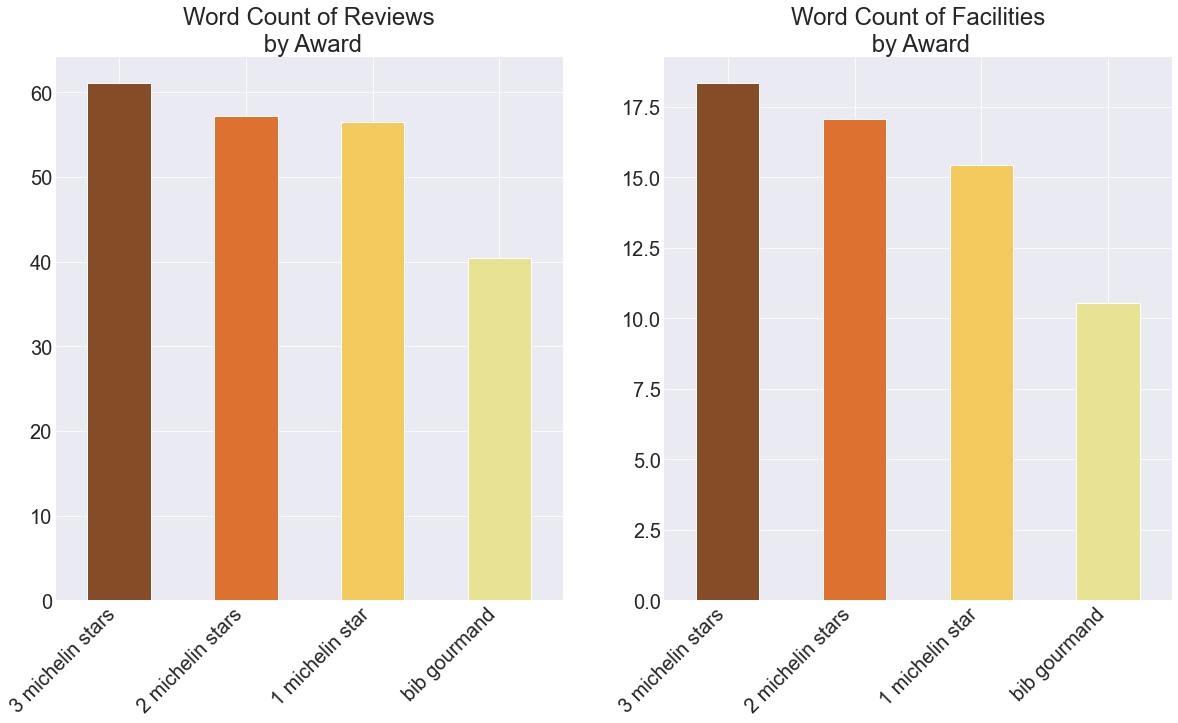

In [96]:
facilities_wc_by_award = f_train.groupby('award').word_count.mean()
reviews_wc_by_award = train.groupby('award').word_count.mean()

# REVIEWS
viz_reviews_wc_by_award = reviews_wc_by_award.sort_values(ascending=False)
Hex_Codes_Earthy = ['#854d27', '#dd7230', '#f4c95d', '#e7e393', '#04030f']

#create a bar plot
plt.subplot(1,2,1)
viz_reviews_wc_by_award.plot(kind='bar', title='Word Count of Reviews\n by Award', ylabel='',
         xlabel='',fontsize =20, color=Hex_Codes_Earthy)
plt.xticks(rotation=45, ha='right')

# FACILITIES
viz_facilities_wc_by_award = facilities_wc_by_award.sort_values(ascending=False)
Hex_Codes_Earthy = ['#854d27', '#dd7230', '#f4c95d', '#e7e393', '#04030f']

#create a bar plot
plt.subplot(1,2,2)
viz_facilities_wc_by_award.plot(kind='bar', title='Word Count of Facilities\n by Award', ylabel='',
         xlabel='',fontsize =20, color=Hex_Codes_Earthy)
plt.xticks(rotation=45, ha='right')

**Verify Assumptions**
* How big is sample size?
* If sample size is significantly > 30, we don't have to worry about normality (CLT!!)

In [85]:
# Levene

from scipy import stats

t_stat, p_val = stats.levene(reviews_wc_by_award, facilities_wc_by_award)

# Set Alpha α
α = Alpha = alpha = 0.05

if p_val < α:
    print('equal_var = False (we cannot assume equal variance)')
    
else:
    print('equal_var = True (we will assume equal variance)')
    
print('_______________________________________________________________')  
print(f't-stat: {t_stat}')
print(f'p-value: {p_val}')

equal_var = True (we will assume equal variance)
_______________________________________________________________
t-stat: 0.5550858890436922
p-value: 0.4843973908185633


### Test Hypothosis

In [86]:
# Pearson's-R

alpha = 0.05
r, p_val = stats.pearsonr(reviews_wc_by_award, facilities_wc_by_award)
    
if p_val < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')
r= r.round(4)
p_val = p_val.round(4)
print('_____________________')  
print(f'correlation {r}')
print(f'p-value {p_val}')

Reject the null hypothesis
_____________________
correlation 0.9833
p-value 0.0167


<div class="alert alert-info">

### Takeaways:

### Q6. Is there a relationship between Reviews and Facilities?

### YES reviews **has** a ```significant relationship``` with facilities as verified by Pearson's-R test

<div class="alert alert-warning">

## Question 7: Is there a relationship between<br> Tri-Gram [two, tasting, menu] or<br> Tri-Gram [three, tasting, menu] and award?

### Hypothesis

two_tail, three_sample  

* Continuous or Discreat?  
    * Continuous (award.value_count) vs Discreat (trigram_1, trigram_2) = **ANOVA**
        * T-Test = ```Discreat``` vs ```Continuous```  
        * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
        * $Chi^2$ = ```Discreat``` vs ```Discreat``` 
        * ANOVA = ```Continuous``` vs 1_or_More nominal or ordinal (Discreat) (analysis of variance) 
<br>
<br>
* $𝐻_0$: The opposite of what I am trying to prove  
    * $H_{0}$: award **is NOT** ```dependent``` on Tri_gram_1 or Tri_gram_2  
    * ```award``` != ```trigram_1``` != ```trigram_2``` 
<br>
<br>
* $𝐻_𝑎$: What am I trying to prove  
    * $H_{a}$: award **is** ```dependent``` on Tri_gram_1 or Tri_gram_2  
    * ```award``` == ```trigram_1``` == ```trigram_2``` 

### Visualization

In [87]:
# subsetting the data:
award = train[train.lemmatized.str.contains('two tasting menu')].award.value_counts()
trigram_1 = train[train.lemmatized.str.contains('two tasting menu')].award.value_counts()
trigram_2 = train[train.lemmatized.str.contains('three tasting menu')].award.value_counts()

trigram_1_df = train[train.data.str.contains('two tasting menu')]
trigram_2_df = train[train.data.str.contains('three tasting menu')]

(array([0, 1, 2]),
 [Text(0, 0, '1 michelin star'),
  Text(1, 0, '2 michelin stars'),
  Text(2, 0, '3 michelin stars')])

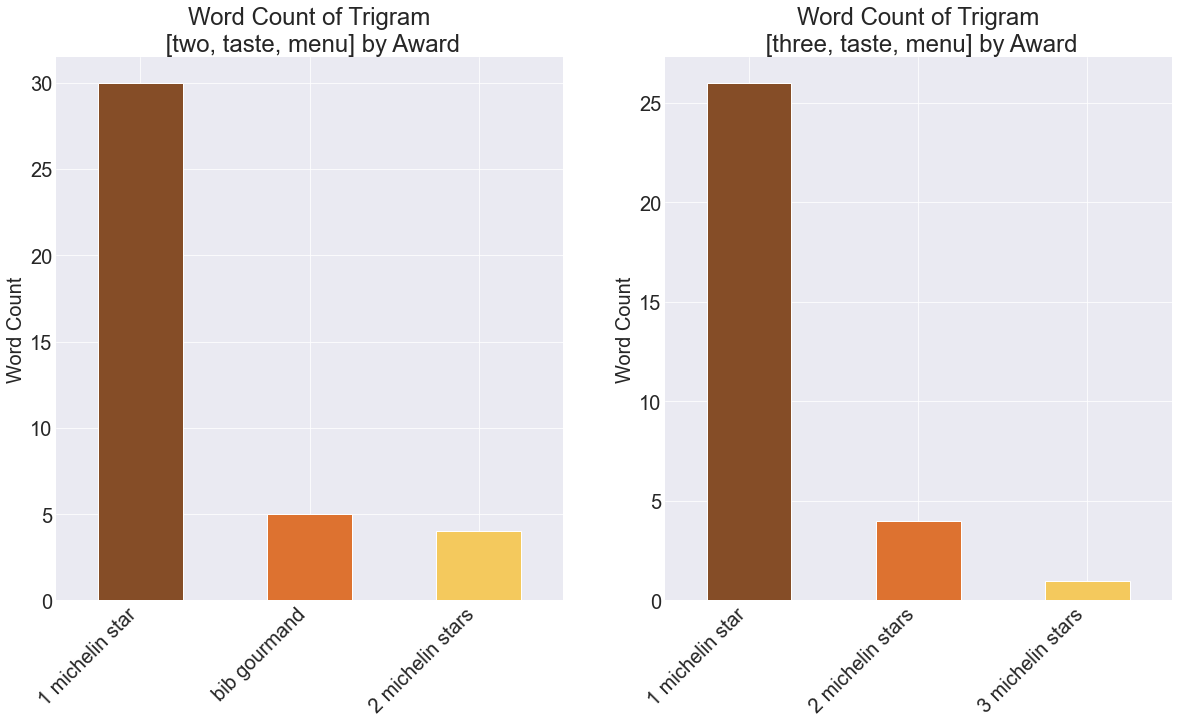

In [90]:


# REVIEWS
viz_two_taste_trigram = trigram_1_df['award'].value_counts(sort=True)
Hex_Codes_Earthy = ['#854d27', '#dd7230', '#f4c95d', '#e7e393', '#04030f']

#create a bar plot
plt.subplot(1,2,1)
viz_two_taste_trigram.plot(kind='bar', title='Word Count of Trigram\n [two, taste, menu] by Award', ylabel='Word Count',
         xlabel='',fontsize =20, color=Hex_Codes_Earthy)
plt.xticks(rotation=45, ha='right')

# FACILITIES
viz_three_taste_trigram = trigram_2_df['award'].value_counts(sort=True)
Hex_Codes_Earthy = ['#854d27', '#dd7230', '#f4c95d', '#e7e393', '#04030f']

#create a bar plot
plt.subplot(1,2,2)
viz_three_taste_trigram.plot(kind='bar', title='Word Count of Trigram\n [three, taste, menu] by Award', ylabel='Word Count',
         xlabel='',fontsize =20, color=Hex_Codes_Earthy)
plt.xticks(rotation=45, ha='right')

**Verify Assumptions**
* How big is sample size?
* If sample size is significantly > 30, we don't have to worry about normality (CLT!!)

In [91]:
# Levene

from scipy import stats

t_stat, p_val = stats.levene(award, trigram_1, trigram_2)

# Set Alpha α
α = Alpha = alpha = 0.05

if p_val < α:
    print('equal_var = False (we cannot assume equal variance)')
    
else:
    print('equal_var = True (we will assume equal variance)')
    
print('_______________________________________________________________')  
print(f't-stat: {t_stat}')
print(f'p-value: {p_val}')

equal_var = True (we will assume equal variance)
_______________________________________________________________
t-stat: 0.0006138735420503332
p-value: 0.9993863775994478


In [94]:
# Bartlett's

from scipy.stats import bartlett

# Bartlett's test in Python with SciPy:
stat, p_val = bartlett(award, trigram_1, trigram_2)

# Set Alpha α
α = Alpha = alpha = 0.05

if p_val < α:
    print('equal_var = False (we cannot assume equal variance)')
    
else:
    print('equal_var = True (we will assume equal variance)')
    
print('_______________________________________________________________')  
print(f'stat: {stat}')
print(f'p-value: {p_val}')

equal_var = True (we will assume equal variance)
_______________________________________________________________
stat: 0.012439875845761218
p-value: 0.9937993658475142


### Test Hypothosis

In [93]:
# Anova Test
import scipy.stats as stats

"""The dependent variable must be a continuous (interval or ratio) level of measurement. 
The independent variables in ANOVA must be categorical (nominal or ordinal) variables. 
Like the t-test, ANOVA is also a parametric test and has some assumptions. 
ANOVA assumes that the data is normally distributed."""

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
f_val, p_val = stats.f_oneway(award, trigram_1, trigram_2)

# Set Alpha α
α = Alpha = alpha = 0.05

if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

print('-----------------------------------')
print(f'f_val: {f_val}')
print(f'p_val: {p_val}')

Fail to reject the null hypothesis
-----------------------------------
f_val: 0.03439011284255776
p_val: 0.9663835314416852


<div class="alert alert-info">

### Takeaways:

#### **Question 7:** Is there a relationship between<br> Tri-Gram [two, tasting, menu] or<br> Tri-Gram [three, tasting, menu] and award?

### NO there are no significant relationships or dependancies as verified by ANOVA test

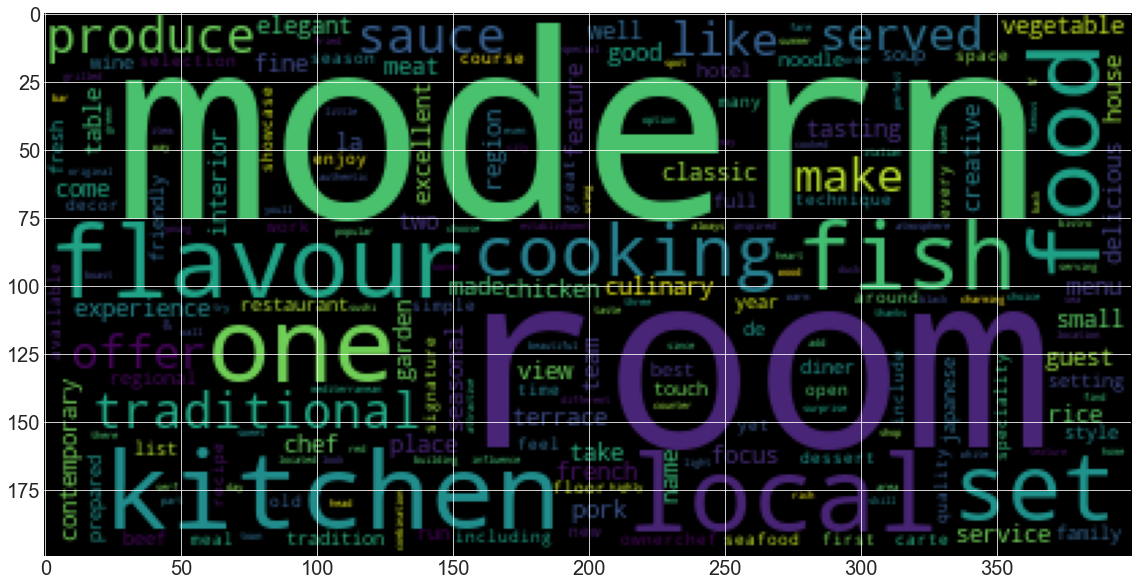

In [95]:
e.generate_word_cloud(train.lemmatized)

## Exploration Summary

- "Bib Gourmand" Award Level is the most common award category (baseline is 50.3%)
- France has the most Michelin awarded restaurants, followed by Japan, Italy, U.S.A and Germany)
- Restaurants awarded three (3) Michelin stars had reviews with the most words, and Bib Gourmand Restaurants had the fewest word count
- Restaurants awarded three (3) Michelin stars had the highest sentiment score, and Bib Gourmand restaurants had the lowest sentiment score
- "Dish", "Ingredient", "Flavour" are the most common words
- "Wine List", "La Carte", "Tasting Menu" are the most common two-word combinations (bi-grams)
- "Two tasting menu" and "Take Pride Place" ar ethe most common three-word combinations (tri-grams)

________________________________________________________________________________________________________

# Modeling

- We utilized accuracy as the evaluation metric
- We developed three different models using different model types: (Decision Tree, Random Forest, Logistic Regression, eXtreme Gradient Boosting (XGBoost))
- The best application (via Hyperparameter tuning) was selected for evaluation of test data
- We utilized the mode of 'Bib Gourmand' as the baseline (50.3%)

We explored several methods of NLP modeling. We elected to utilize as much useful text as possible. Because this is a multilabel classification project we decided that the large string of text would be more useful for finding differences between reviews by award category rating

We trained several models on our training set without hyperparameter tuning to produce models that were 'Good Enough'.

In [ ]:
# Get Baseline
m.get_baseline(train)

### Initial Model Training

In [ ]:
# Run modeling function
m.run_train_and_validate(train, validate)

### Testing selected model on unseen data (Test)

In [ ]:
#Place final model test here

## Modeling Summary

## Takeaways/Conclusions

- Restaurants with higher Michelin award levels have, on average, longer reviews
- Three (3) Star Michelin Restaurant reviews have the highest sentiment levels, but there is a negligible difference between one (1) and two (2) star restaurants

## Recommendations

## Next Steps

- Refining stopwords, removing common words from the model
- Fine-tuning hyperparameters